# 1. Loading a dataset with ANUBIS (optional)

Although not required for this analysis, ANUBIS package provides additional functions to work with insertion data. If needed, you can install this python package from [ANUBIS](https://github.com/CRG-CNAG/anubis) and then run the following code to obtain an anubis dataset:

```python
import anubis_core as ac
all_reads = {}
allfiles = {your_ide1:path1.qins, ..., your_ideN:pathN.qins}

for k, v in allfiles.items():
    all_reads[k] = qt.dataset(v, genome_location).zreads
```


# 2. Case example with *Mycoplasma pneumoniae*

Here we present a series of analysis used for the associated publication. We start first loading the required packages and configurations for this notebook:


In [40]:
# Jupyter magics

%load_ext autoreload
%autoreload 2
#%matplotlib widget

#%matplotlib inline

import re
import glob
import pickle
import sys, os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid", {'axes.grid' : False})

from IPython.display import clear_output
clear_output(wait=True)

# Custom functions from protinseq_tools.py (provided along this notebook)
import protinseq_tools as pst

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.1. Comprehensive omics information for *M. pneumoniae*

We also provide a series of files including relevant information in `./data/` for plotting (such as associate omic data) and a minimal control-condition library example (Cm A and Cm B grown with 15 ug/ml of chloramphenicol) to showcase some analysis. This information is mostly saved in pickle format for which we provide a basic set of functions to upload. The files included are:

- `example_reads.dat`: a dictionary {ide:array} where ide represents the unique identifier of the library and array includes the read count of insertion per genome base. 
- `myco_pneumoniae_m129.gb`: latest version of the genome of *M. pneumoniae* in genbank format.
- `orfs_df.tsv`: a dataframe with the start, end and strand annotation of the ORFs to explore (you can produce this with RanSEPs orffinder function).
- `annotations.dat`: a list of dictionaries with orfs, ncbi genes, functional rnas and MPN to mpneu translation dictionaries. 
- `intergenic.dat`: a dictionary with intergenic annotations. 
- `sequences.dat`: a list of dictionaries with nt and aa sequences. 
- `omics.dat`: RNA-Seq pile-ups and peptides identified by MS. 
- `mycoinfo.tsv`: a dataframe containing comprehensive information for each annotation analyzed. 


In [6]:
all_reads                              = pst.LoadPickle('./data/example_reads.dat')
genome_location                        ='./data/myco_pneumoniae_m129.gb'            # We provide just the location
orfs_df                                = pd.read_csv('./data/orfs_df.tsv', sep='\t', index_col=0)
orfs, ncbi, rnas, mpn2mpneu, mpneu2mpn = pst.LoadPickle('./data/annotations.dat')
igan                                   = pst.LoadPickle('./data/intergenic.dat')
nt_seqs, aa_seqs                       = pst.LoadPickle('./data/sequences.dat')
piles, peptide_map                     = pst.LoadPickle('./data/omics.dat')
extmycoinfo                            = pd.read_csv('./data/mycoinfo.tsv', sep='\t', index_col=0)

/tmp/ipykernel_721805/1943786631.py:8: DtypeWarning: Columns (8,9,22,29) have mixed types. Specify dtype option on import or set low_memory=False.
  extmycoinfo                            = pd.read_csv('./data/mycoinfo.tsv', sep='\t', index_col=0)


In [14]:
orfs_df

,start,end,strand,alt_ann
gene,,,,
mpneu04917,38,58,+,-1
mpneu30113,33,47,-,-1
mpneu00001,49,132,+,0
mpneu09814,60,173,+,0
mpneu04918,62,94,+,-1
...,...,...,...,...
mpneu14813,816260,816277,-,-1
mpneu09813,816293,816322,+,-1
mpneu14812,816299,816325,-,-1


In [15]:
extmycoinfo

,gene,start,end,strand,ntlen,aalen,ann_type,alt_ann,localization,function,operon,expression,cprna,msexp,mspepts,cpprot,ureacp,sdscp,meancp,hlprot,refdens,refesse,ranseps,rbs,homology,predfun,tm,sp,segtm,complex
0,MPN001,692,1834,+,1142,380.0,ncbi,1,Cytoplasm,DNA synthesis/modifications/repair/conformation,1.0,8.459389,0.226970,116.0,33.0,508.1,508.1,663.5,867.03,8.06,0.004,E,0.993,1.0,6.0,dnaN,0.0,0.0,o,2.0
1,MPN002,1838,2767,+,929,309.0,ncbi,1,Cytoplasm,DNA synthesis/modifications/repair/conformation,1.0,7.297465,0.126930,115.0,22.0,34.9,34.9,36.2,66.62,4.83,0.208,F,0.998,0.0,6.0,xdj1,0.0,0.0,o,1.0
2,MPN003,2869,4821,+,1952,650.0,ncbi,1,Cytoplasm,DNA synthesis/modifications/repair/conformation,2.0,8.597315,0.234930,115.0,48.0,267.8,267.8,350.9,268.72,6.07,0.003,E,0.996,1.0,6.0,gyrB,0.0,0.0,o,2.0
3,MPN004,4821,7340,+,2519,839.0,ncbi,1,Cytoplasm,DNA synthesis/modifications/repair/conformation,2.0,8.297611,0.183630,116.0,54.0,280.6,280.6,359.0,244.59,7.05,0.002,E,0.994,0.0,6.0,gyrA,0.0,0.0,o,2.0
4,MPN005,7312,8574,+,1262,420.0,ncbi,1,Cytoplasm,tRNA synthases,2.0,7.974636,0.177735,115.0,28.0,296.0,296.0,177.8,249.56,7.87,0.002,E,0.984,1.0,6.0,serS,0.0,0.0,o,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34196,IGMM1659,800442,800542,-,100,NaN,igan,0,NaN,Functional RNA,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,0.000,0.0,0.0,RNA,0.0,0.0,0,0.0
34197,IGMM1660,800627,800644,-,17,NaN,igan,0,NaN,Functional RNA,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,0.000,0.0,0.0,RNA,0.0,0.0,0,0.0
34198,IGMM1661,805849,805870,-,21,NaN,igan,0,NaN,Functional RNA,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,0.000,0.0,0.0,RNA,0.0,0.0,0,0.0
34199,IGMM1662,813449,813467,-,18,NaN,igan,0,NaN,Functional RNA,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,0.000,0.0,0.0,RNA,0.0,0.0,0,0.0


## 2.2. Metrics by frame

To retrieve the main metrics by frame for an annotation in the library:

In [16]:
pst.get_f_metric(all_reads['Cm_B_15_neg_1'], ncbi['MPN447'], thr=0) # Threshold can be used to remove insertions by minimum value of reads. 

,frame,metric,value
0,1,R,47487.000000
1,1,I,407.000000
2,1,coverage,0.399542
3,2,R,360.000000
4,2,I,24.000000
5,2,coverage,0.023560
6,3,R,30.000000
7,3,I,13.000000
8,3,coverage,0.012762


Text(0, 0.5, 'Nr Ins')

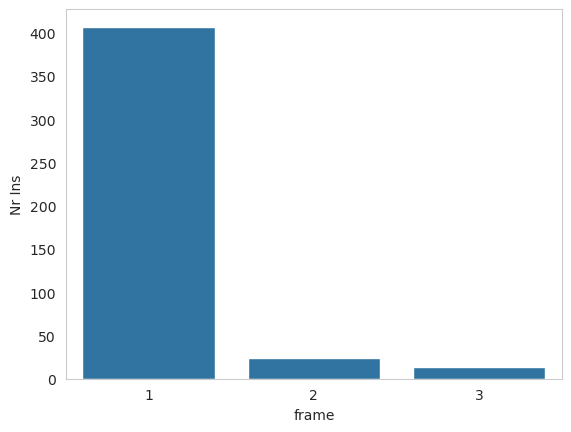

In [17]:
df = pst.get_f_metric(all_reads['Cm_B_15_neg_1'], ncbi['MPN447'])
plt.figure()
sns.barplot(x='frame', y='value', data=df[df['metric']=='I'])
plt.ylabel('Nr Ins')

It can be observThis can be iterated to collect multiple metrics per sample for genes.

## 2.3. Basic plotting function

This function interacts with the function pst.psplot function to provide complex visualizations of the insertions profiles:

In [62]:
def plot_ide(ide='region', coords=None,
             query=None, wdw_size=5, tracks=[1,1,1,1,1,1,1], strand_specific=True, extra=100, 
             list_of_samples=None, profile=None, alt_start=True):
    if ide!='region':
        coords = list(extmycoinfo.loc[extmycoinfo['gene']==ide, ['start', 'end', 'strand']].values[0])
    elif coords:
        alt_start=False
        pass
    if strand_specific:
        if coords[-1]=='+':        
            q = 'pos'
        else:
            q = 'neg'
    # Define query
    if profile:
        profile = {'custom':profile}
    else:
        if list_of_samples:
            profile = {k:all_reads[k] for k in list_of_samples}
        elif query:
            if type(query)==str:
                query = [query]
            if type(query[0])==str:
                if strand_specific:
                    query.append(q)
                profile = ps.return_sample(all_reads, select_all=query)
            elif type(query[0])==list:
                if strand_specific:
                    query[0].append(q)
                if len(query)==2:
                    profile = ps.return_sample(all_reads, select_all=query[0], select_any=query[1])
                elif len(query)==3:
                    profile = ps.return_sample(all_reads, select_all=query[0], select_any=query[1], exclude=query[2])
            else:
                sys.exit('provide accepted query')
        else:
            profile = None    
    pst.psplot(coords=coords, ide=ide, 
               piles=piles, profile=profile, 
               nt_seq=nt_seqs.get(ide, None), alt_start=alt_start,
               # query=query,
               peptides=peptide_map.get(ide, None), tracks=tracks, wdw_size=5,
               aa_seq=aa_seqs.get(ide, None), extra=extra, annotation=orfs_df)

### 2.3.1. Plotting a gene by name:

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

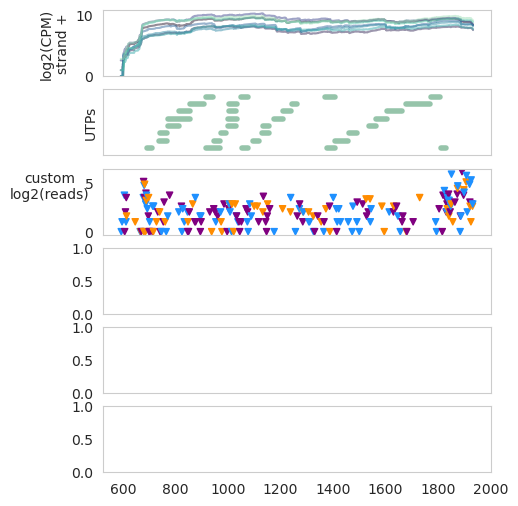

In [ ]:
plot_ide(mpn2mpneu['MPN001'], profile=list(all_reads['Cm_A_15_pos_1']))

Each row presents (in order):
- RNA-Seq profile
- unique tryptic peptides identified by Mass-spec
- mapped insertions colored by frame (as many samples as provided)
- the transmembrane prediction with TMHMM
- the accumulated windows analysis of insertion profiles
- the map of annotation in the region

Notice the sample orientation identifier (positive strand) matches the one of the gene. 

### 2.3.2. Minimal plot (no omics, or no tmhmm)

**Update** the TMHMM 2.0 library seems to be incompatible with most of the newer numpy version. For a minimal plot just to display annotation and frame selection (or if you lack the rest of the omic data), you can always do:

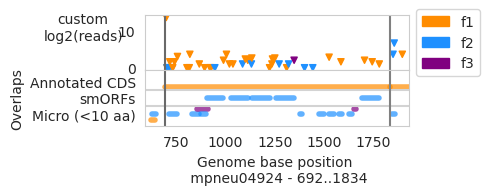

In [80]:
plot_ide(mpn2mpneu['MPN001'], profile=list(all_reads['Cm_B_15_pos_1']), tracks=[0,0,1,0,0,0,1])

### 2.3.3. Plotting multiple profiles:

The function will check directly in the all_reads dictionary, this can be use to plot all replicates with a given text match. In this case, we plot the gene MPN593. Green lines in the transmembrane track represent 'ruptures' in the profile, these are points of changes in the distribution for the insertion prediction which in this case are representative of the transmembrane protein topology:

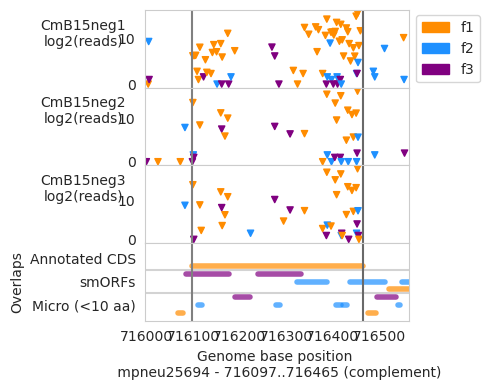

In [81]:
plot_ide(ide='mpneu25694', list_of_samples=[k for k in all_reads.keys() if 'Cm_B_15_neg' in k], tracks=[0,0,1,0,0,0,1]) # Only annotations

### 2.3.4. Selecting which elements to plot by coordinates:

You can also plot specific coordinates hiding elements which are relative to a gene with the tracks argument. In this case we plot the example from the manuscript supplementary figure 7:

In [11]:
plot_ide(coords=[543300,553520, '-'], list_of_samples=[k for k in all_reads.keys() if '_15_neg_1' in k], tracks=[0,0,1,0,0,0,0])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 2.4. Metagene comparative

A metagene can be quickly retrieved for a list of annotations by:

In [12]:
your_annotations = [v for k,v in ncbi.items() if v[-1]=='-']   # annotations from NCBI in the complementary strand
metagene = pst.metagene_by_frame(all_reads['Cm_B_15_neg_1'], your_annotations, frame=1, metric='R', step=100, gl=816394)

- accepted_metrics by the function include: `'sum', 'std', 'mean', 'median', 'count', 'L', 'min', 'max', 'I', 'dens', 'R', 'RI', 'CPM', 'RPKM'.`
- step defines the number of bins (100 in this case). 
- gl represents the genome length, used for normalization purposes. 

Then this metagene can be plotted:

In [13]:
plt.figure(figsize=(10,2))
plt.plot(np.sum(metagene, axis=1))
plt.ylabel('Sum of reads')
plt.xlabel('bin')
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …